## CS4243 Lab 2: Hough Transform

**ASSIGNMENT SUBMISSION DEADLINE: 24.02 22:00**
- The functions to be implemented are given in `lab2.py`, along with the instructions for each function. You need to fill in the codes which start with `# YOUR CODE HERE` and end with `# END`
- The test images are given in folder `data/input` and sample outputs are provided in `data/output`
- Most of the functions are available in built-in libraries, but you are not allowed to use them in this assignment except for `numpy`. Exceptions will be explicitly stated.

**Attention**:
- Please use python with version >= 3.5.4, and install the libs provided in requirements.txt via `pip install -r requirements.txt`.
- Please do not change the inputs arguments of the functions in `lab2.py`, otherwise your implementation would fail to pass the test.
- Please do not change the structure of files in the whole folder of this assignment, otherwise TA may mark your code wrongly.
- As long as your output is close to the expected answer, you will get full credit.

**SUBMISSION INSTRUCTIONS:**

Upload to Canvas your completed `lab2.py` and `lab2.ipynb` by zipping them into a file named AXXX1_AXXX2.zip, where AXXX is the student number of the group members. Submit one file per group. Missing files, incorrectly formatted code that does not run, etc. will be penalized.

If you have any question regarding this lab, do not hesistate to ask questions under the Labs section on Canvas Discussions. You can also attend any lab slot for FAQs.

In [6]:
import cv2 
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
# Disable jedi autocompleter
%config Completer.use_jedi = False

In [7]:
from lab2 import *
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## TASK 1: EDGE DETECTION (30%) 

In this task, we will implement the Canny Edge Detection Algorithm learnt in the lecture.

We can start with the image of a check board:

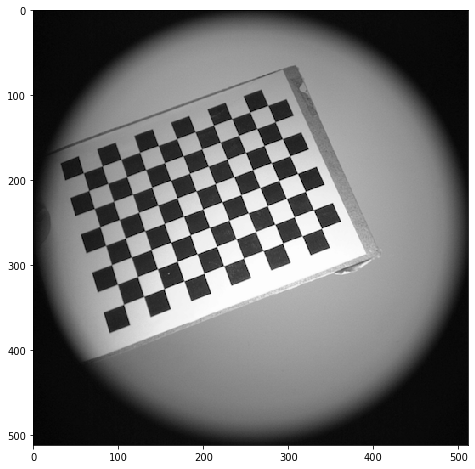

In [8]:
checker_file_path="data/input/circled_checkerboard.png"
checker_im = cv2.imread(checker_file_path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(checker_im, cv2.COLOR_BGR2RGB))

**1.1 Implements a simplified Gaussian kernel (5%)** 

First, implement the function `make_gaussian_kernel` that takes in two arguments: `ksize` and `sigma` which are respectively the kernel size and sigma value.

**Goal**: complete the function `make_gaussian_kernel`.

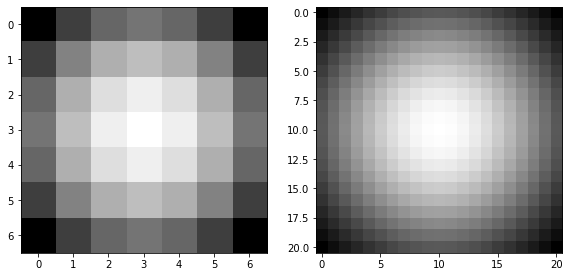

In [9]:
kernel_7_5 = make_gaussian_kernel(7,5)
kernel_21_9 = make_gaussian_kernel(21,9)

plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.subplot(131)
plt.imshow(kernel_7_5)

plt.subplot(132)
plt.imshow(kernel_21_9)

gaussian_kernel_sample_1 = 'data/output/gk_75.npy'
gaussian_kernel_sample = np.load(gaussian_kernel_sample_1)
assert np.max(np.abs(gaussian_kernel_sample - kernel_7_5)) < 1e-10, "Your solution is incorrect."

gaussian_kernel_sample_2 = 'data/output/gk_219.npy'
gaussian_kernel_sample = np.load(gaussian_kernel_sample_2)
assert np.max(np.abs(gaussian_kernel_sample - kernel_21_9)) < 1e-10, "Your solution is incorrect."

**1.2 Performs Gaussian blurring**

We provide you with the function `cs4243_blur` that does what its name suggests. You can combine it with the function `make_gaussian_kernel` to blur an image.

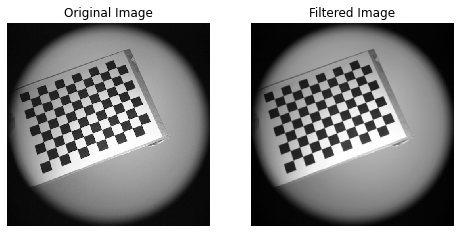

In [11]:
blurred_checker = cs4243_blur(checker_im, make_gaussian_kernel(3,3))

**2 Compute gradient orientations and magnitudes (5%)**


First you will need to compute gradients in x and y direction by convolving the image with the appropriate Sobel filters.

Then compute gradient magnitudes.

Finally, compute gradient orientations (Hint: you may find `np.arctan2` useful).


**Goal**: Complete the `estimate_gradients` function.

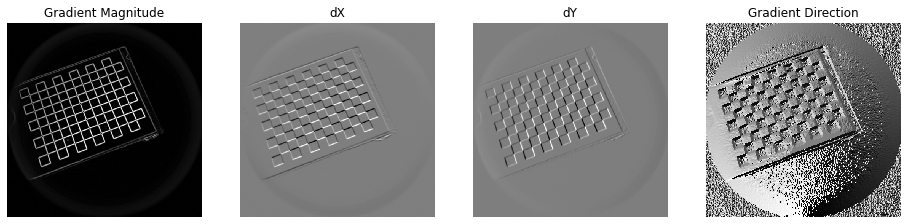

In [14]:
d_mag, d_angle= estimate_gradients(blurred_checker)

**3 Perform non maximum suppression (10%)**

**Goal**: Complete the `non_maximum_suppression` and `non_maximum_suppression_interpol` function.

*Note: For the rest of this lab, you can use either version.*

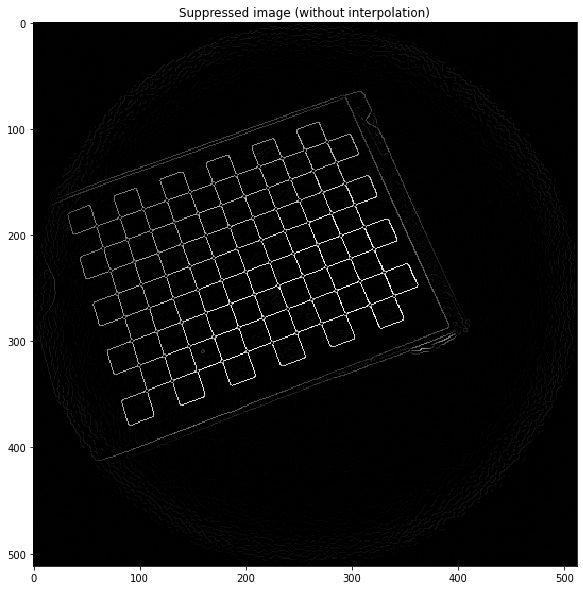

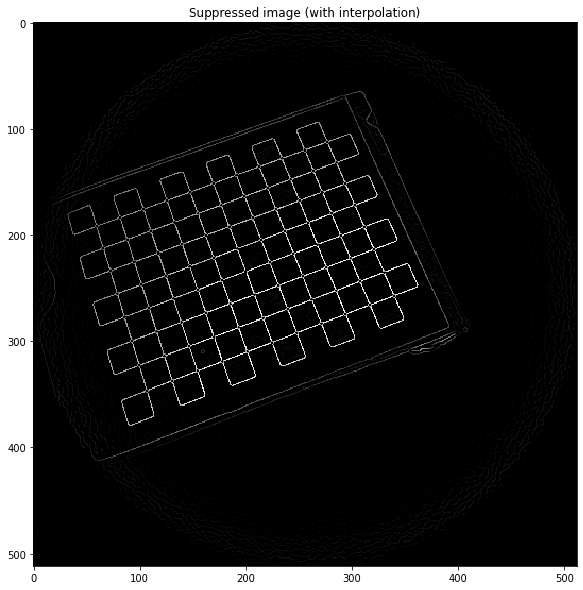

In [10]:
supp = non_maximum_suppression(d_mag, d_angle)
supp_interpol = non_maximum_suppression_interpol(d_mag, d_angle)

**4 Perform double thresholding (5%)**

**Goal**: Complete the `double_thresholding` function.

*(Note: the visualization may seem a bit off, this is because some pixels are not displayed)*

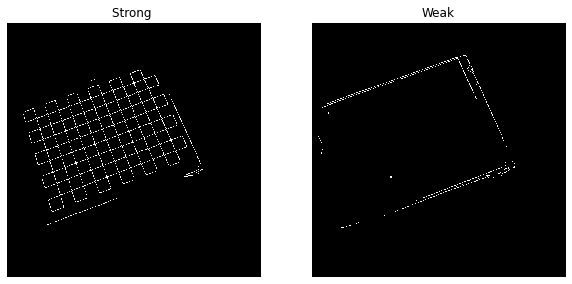

In [11]:
weak_edges, strong_edges = double_thresholding(supp, perc_weak=0.1, perc_strong=0.3)

**5 Perform edge-linking (5%)**

**Goal**: Complete the `edge_linking` function.

You can experiment with double-thresholding step using parameters `perc_weak` and `perc_strong`to get the best edge image. 

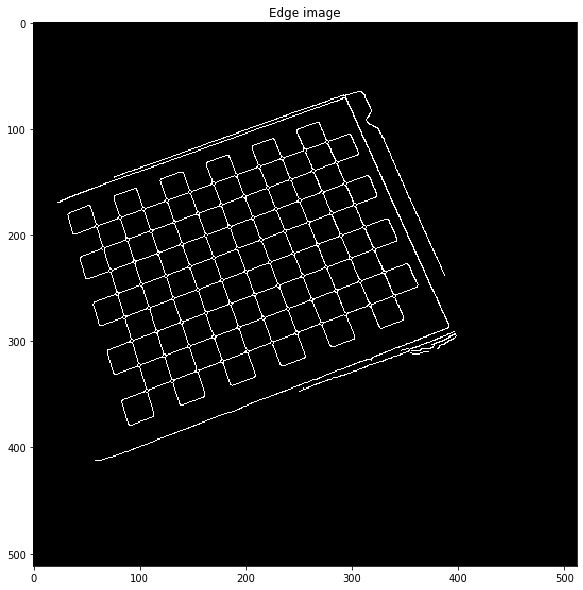

In [12]:
checker_edge = edge_linking(weak_edges, strong_edges)

## TASK 2: LINEAR HOUGH TRANSFORM (20%)

In this task, we will use the edge image to perform Hough voting.

**QUESTION**: Why do you think we need to operate on the edge image instead of the full image? **(1%)**

**ANSWER**: The Hough transform only works with edges and not intensity values. The full image provides only intensity values and does not directly tell where the edges are. In particular, the Hough transform involves iterating over the edge points in the image in the step where the accumulator array is updated, and the edge points can only be found from the edge image. To find where the lines in the image, we need to first know where the edges are. Thus, we need to preprocess the original (full) image to find the pixels that are detected as edges. With this binary edge image, we can plot the points detected as edges in the Hough space and use the voting based approach to detect the actual lines that from the points that form the edges in the image. This is why we need the edge points in the first place.

Now, you will need to use the pixels from the edge image to cast votes in the Hough space. 

**Goal**: Implement the function `hough_vote_lines`. **(15%)**


We provide you `find_peak_params` to find local maxima. It reads the accumulator array and parameter arrays and returns n+1 
arrays (n is the number of parameters), all of size equal to the number of local maxima. The first array contains bin counts at these maxima in descending order, and subsequent n arrays each contains the value for a parameter, in corresponding order. 

There are also two parameters you can tune for this function: `window_size` and `threshold`, which respectively define the window size for each local maxima and minimum bin count ratio over the maximum count. You are encouraged experiment with these two parameters.

To test your solution, run through the two examples below. For the second example, you will need to generate the edge image first. Then run `detect_lines`. You can see the output image with the lines overlaid on top of the original image. Feel free to experiment with the parameters at various steps.

**Note: If you are using Google Colab, might require running `!pip install matplotlib --upgrade` and restart runtime for matplotlib to work properly.**

**Example 1: Checker (2%)** 

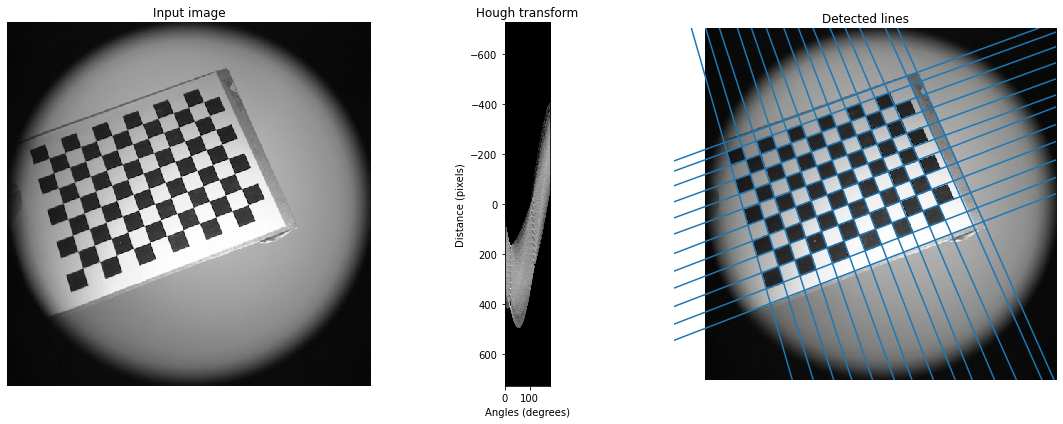

In [13]:
hspace, dists, thetas = hough_vote_lines(checker_edge)
hs_maxima = find_peak_params(hspace, [dists,thetas],10,0.35)

draw_lines(hspace, dists, thetas, hs_maxima, checker_file_path)

Sample answer below:

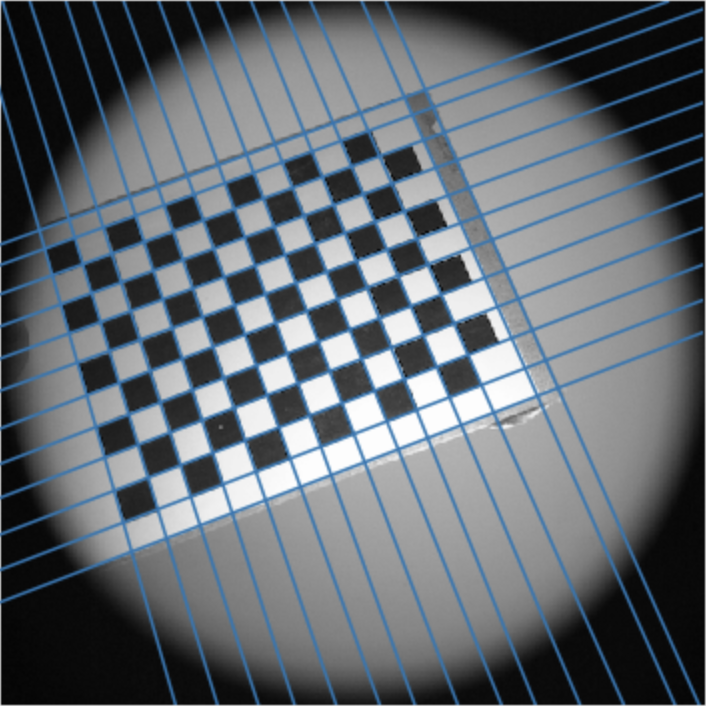

In [14]:
from IPython.display import Image, display
display(Image("data/output/circled_checkerboard_lines.png", width=100, height=100))

**Example 2: 2x2 Rubik's Cube (2%)**

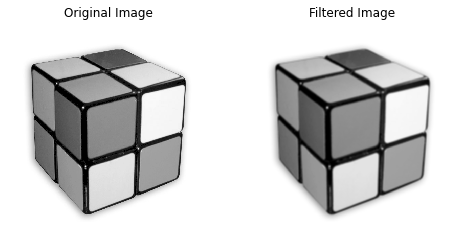

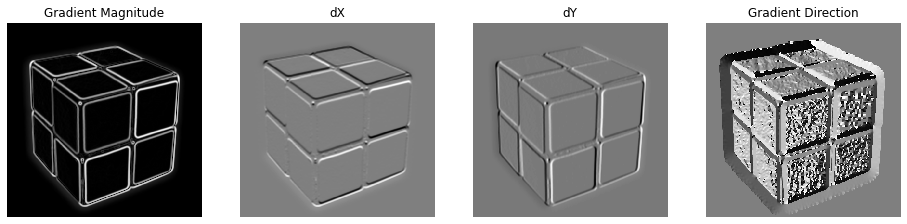

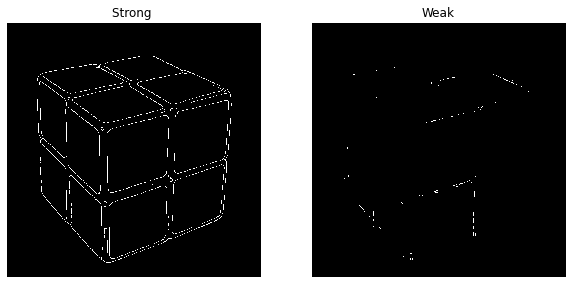

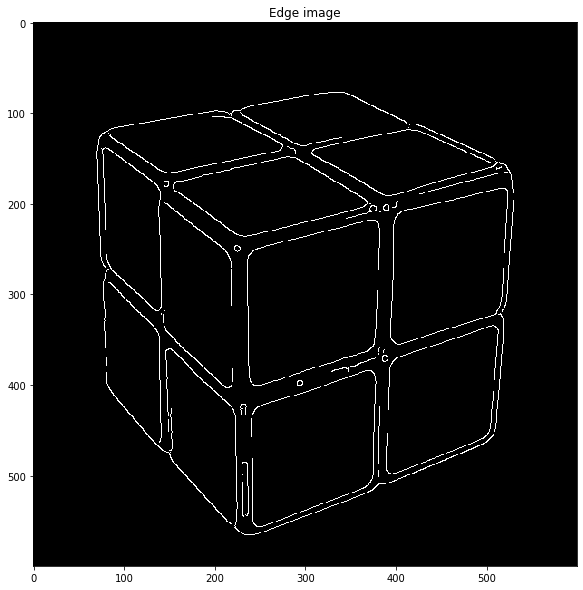

In [15]:
cube_file_path="data/input/rubiks.png"
cube_im = cv2.imread(cube_file_path, cv2.IMREAD_GRAYSCALE)
blurred_cube = cs4243_blur(cube_im, make_gaussian_kernel(7, 3))
d_mag, d_angle= estimate_gradients(blurred_cube)

supp = non_maximum_suppression(d_mag, d_angle, False)
weak_edges, strong_edges = double_thresholding(supp, 0.12, 0.2)

cube_edge = edge_linking(weak_edges, strong_edges)

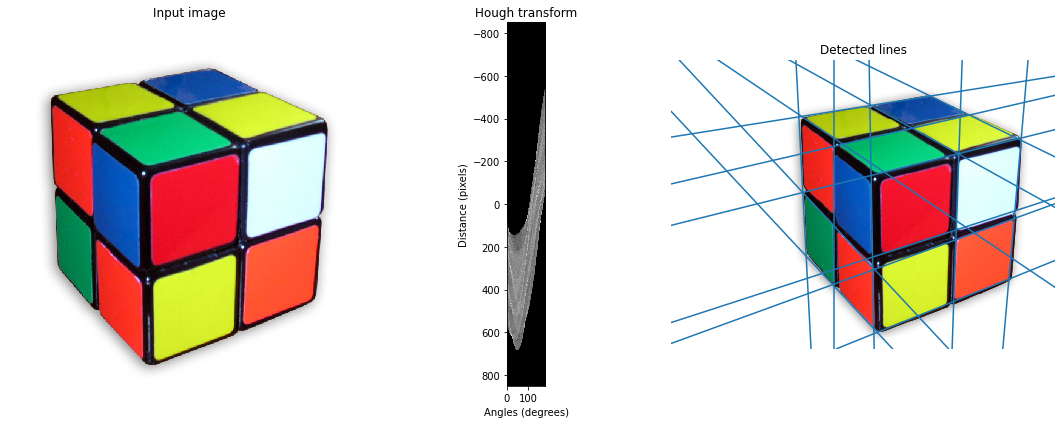

In [16]:
hspace, dists, thetas = hough_vote_lines(cube_edge)
hs_maxima = find_peak_params(hspace, [dists,thetas],25,0.4)
draw_lines(hspace, dists, thetas, hs_maxima, cube_file_path)

Sample answer below:

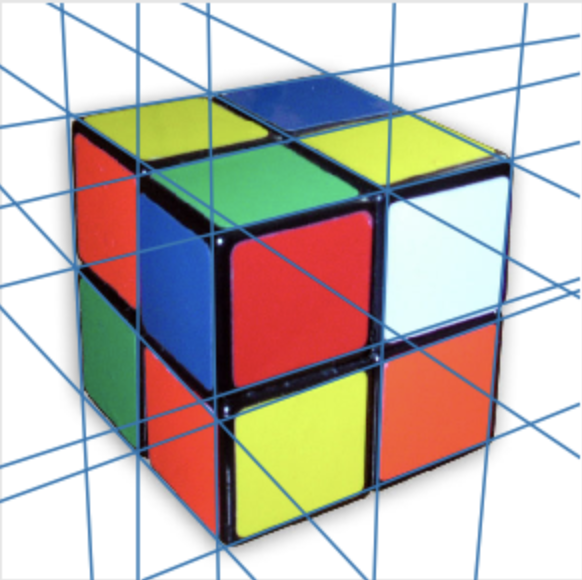

In [17]:
from IPython.display import Image, display
display(Image("data/output/rubiks_lines.png", width=300, height=300))

## TASK 3: CIRCULAR HOUGH TRANSFORM (20%)

In this task, we will do some circle detection. We will again make use of the edge image pixels to vote for parameters and identify the local maxima in the Hough space. Unlike the case for straight lines, the Hough space now will consist of three dimensions: the circle radius (R) and the coordinates of the circle center (X, Y).



**TEST CASE 1: Standard spheres and circles example (2%)**

First, let's take a look at the edge image for this image with a couple of golf balls and other circular shapes.

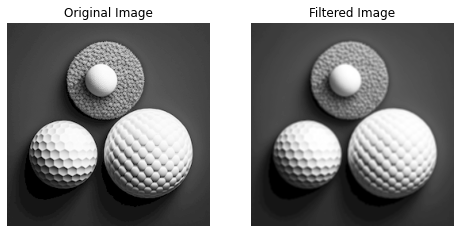

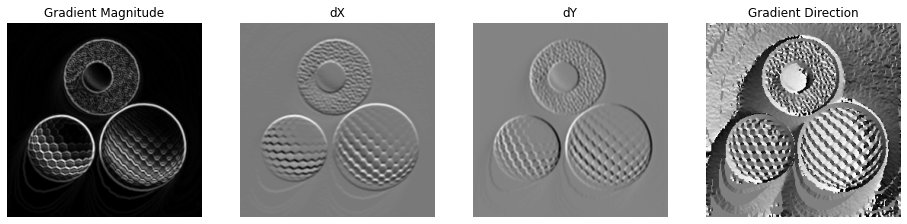

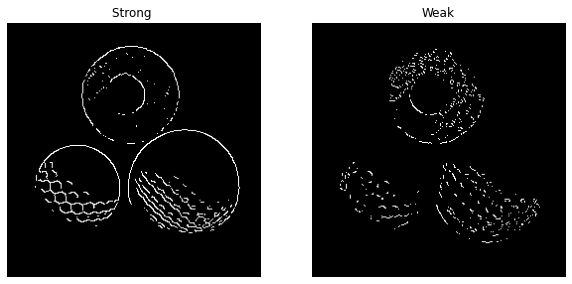

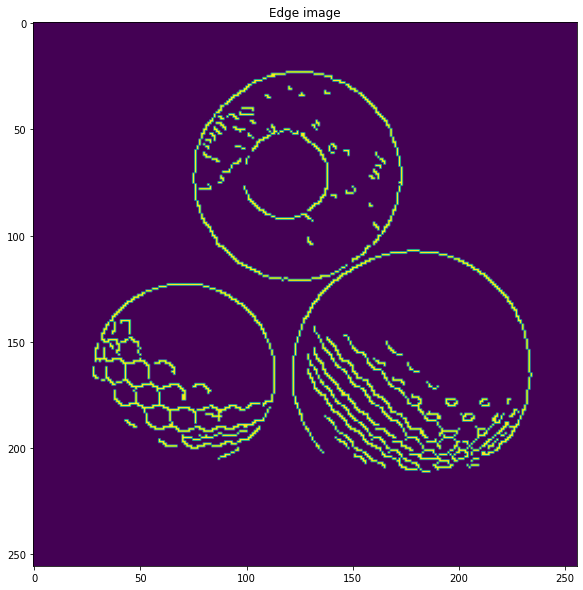

In [19]:
golf_path="data/input/green.png"
golf_im = cv2.imread(golf_path, cv2.IMREAD_GRAYSCALE)
blurred_golf = cs4243_blur(golf_im, make_gaussian_kernel(3, 3))
d_mag, d_angle= estimate_gradients(blurred_golf)

supp = non_maximum_suppression(d_mag, d_angle, False)
weak_edges, strong_edges = double_thresholding(supp, 0.3, 0.4)

golf_edge = edge_linking(weak_edges, strong_edges)

**Goal**: Complete the `detect_circles` function  **(15%)**

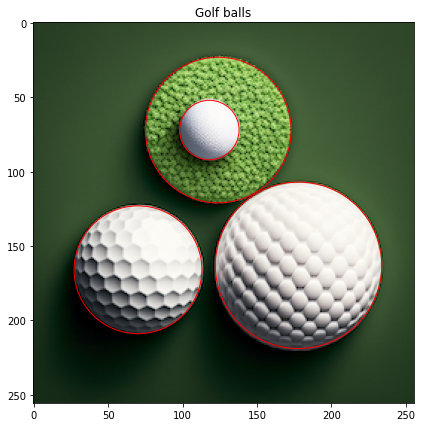

In [20]:
u = hough_vote_circles(golf_edge, radius=[20,58]) # Try to find appropriate radius values 
golf_local = find_peak_params(u[0], [u[1],u[2],u[3]],5,0.7)

# draw_circles(golf_local, golf_path, "Golf balls") # draw_circles might not work, try using draw_circles_v2
draw_circles_v2(golf_local, golf_path, "Golf balls")

Expected answer below:

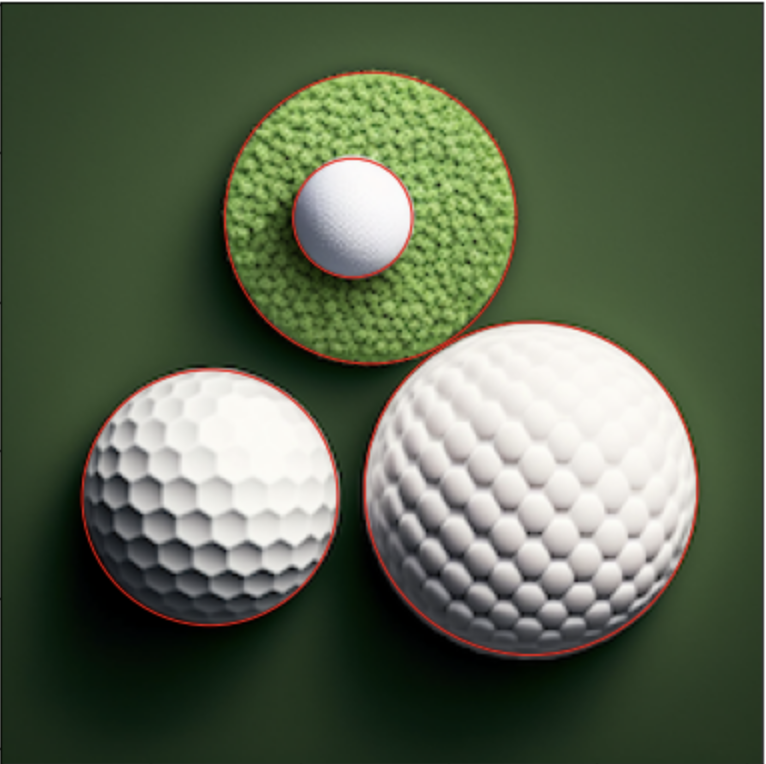

In [25]:
from IPython.display import Image, display
display(Image("data/output/golf_circles.png", width=256, height=256))

**TEST CASE 2: Partial circles (3%)** 

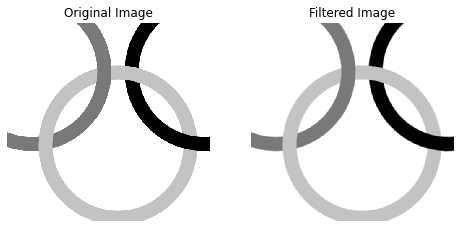

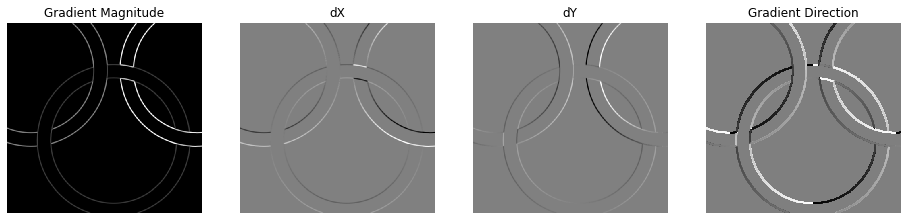

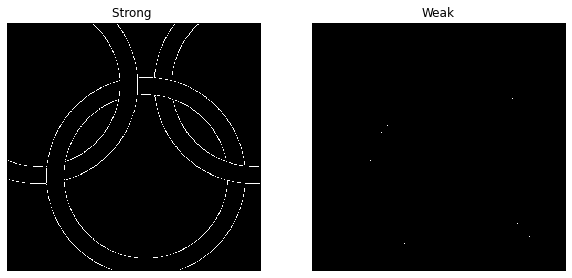

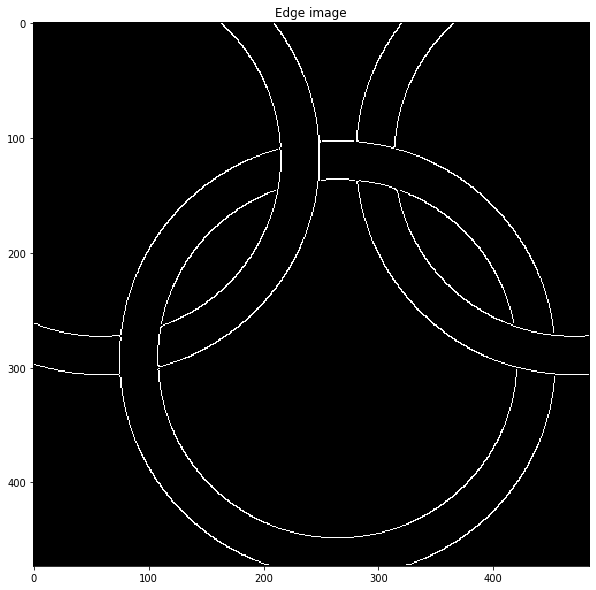

In [ ]:
olympic_path="data/input/olympic_rings.png"
olympic_im = cv2.imread(olympic_path, cv2.IMREAD_GRAYSCALE)
blurred_olympic = cs4243_blur(olympic_im, make_gaussian_kernel(3, 3))
d_mag, d_angle= estimate_gradients(blurred_olympic)
supp = non_maximum_suppression(d_mag, d_angle, False)
weak_edges, strong_edges = double_thresholding(supp, 0.1,0.2)
olympic_edge = edge_linking(weak_edges, strong_edges)

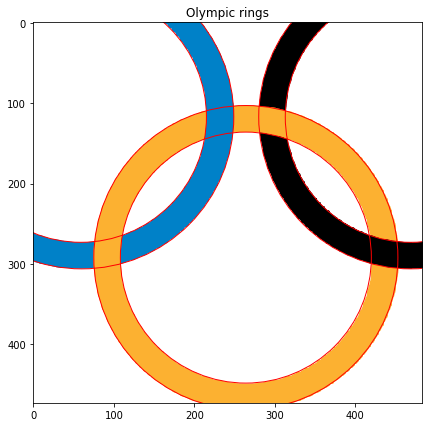

In [ ]:
u = hough_vote_circles(olympic_edge,radius=[100,200])
olympic_local = find_peak_params(u[0], [u[1],u[2],u[3]],8,0.3)
draw_circles_v2(olympic_local, olympic_path, "Olympic rings")

Expected answer below:

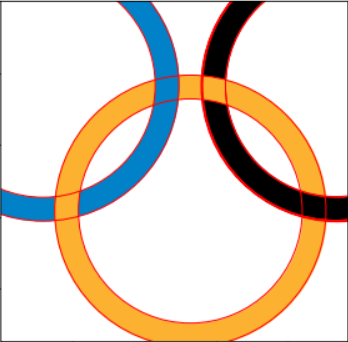

In [ ]:
from IPython.display import Image, display
display(Image("data/output/rings.png", width=300, height=300))

## TASK 4: Exploratory Questions (30%)

The focus of this part is on exploring, it is all right if your output does not match expected output exactly. Remember to enter your answer in the question cells.

**4.1 Weighted Voting (5%)**

Let's take a look at an image of multiple coins with varied sizes

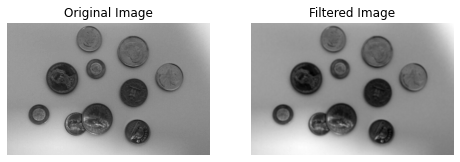

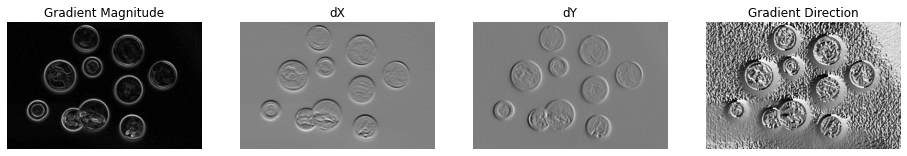

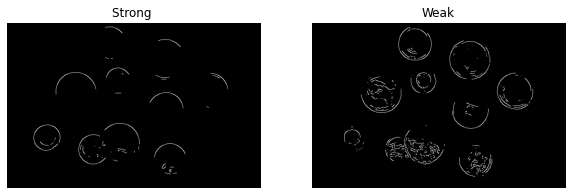

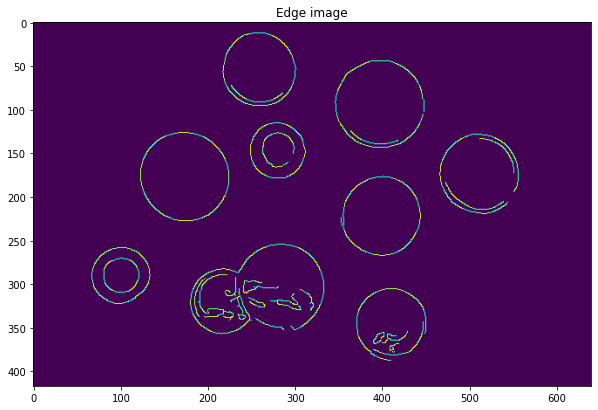

In [26]:
coin_path="data/input/coins.png"
coin_im = cv2.imread(coin_path, cv2.IMREAD_GRAYSCALE)
blurred_coin = cs4243_blur(coin_im, make_gaussian_kernel(5, 3))
d_mag, d_angle= estimate_gradients(blurred_coin)
supp = non_maximum_suppression(d_mag, d_angle, False)
weak_edges, strong_edges = double_thresholding(supp, 0.2, 0.5)

coin_edge = edge_linking(weak_edges, strong_edges)

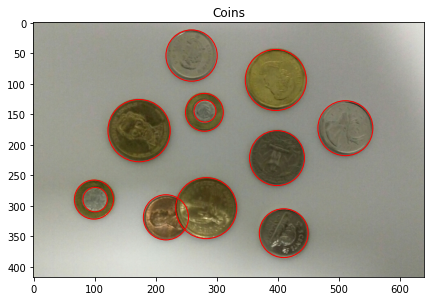

In [28]:
u = hough_vote_circles(coin_edge, radius=[15,75])
coin_local = find_peak_params(u[0], [u[1],u[2],u[3]],5,0.65)
draw_circles_v2(coin_local, coin_path, "Coins")

Expected answer below:

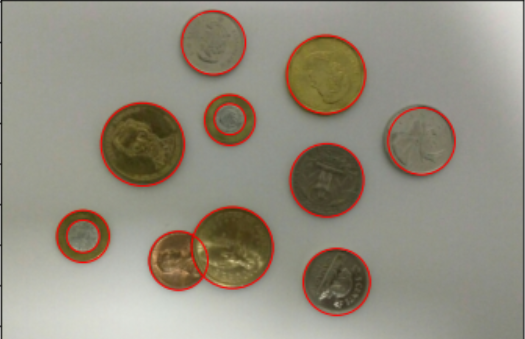

In [29]:
from IPython.display import Image, display
display(Image("data/output/coins_ans.png"))

**QUESTION**: Are you able to detect all the circles (including the circular center area of the two smallest coins? Does changing the parameters for `find_peak_params` help?

**ANSWER**:

**QUESTION**: What adjustments can you make to the votes cast to ensure that circles of all sizes are detected? Make the changes in the function `hough_vote_circles` and run the cell above again (you are allowed to adjust `find_peak_params`). Why do you think the adjustments work?

**ANSWER**:

**4.2 Leveraging gradients (5%)**

**Goal:** Implement `hough_vote_circles_grad`. 

**4.3 Interval / Bin Size (10%)**

Now let's bring the new function to test

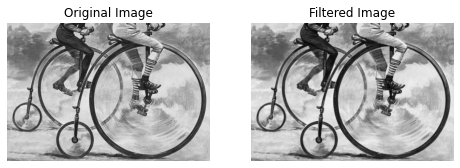

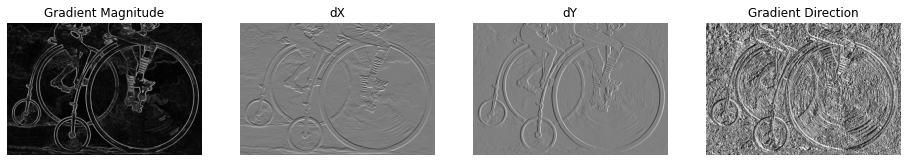

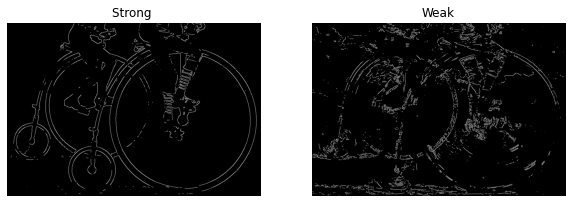

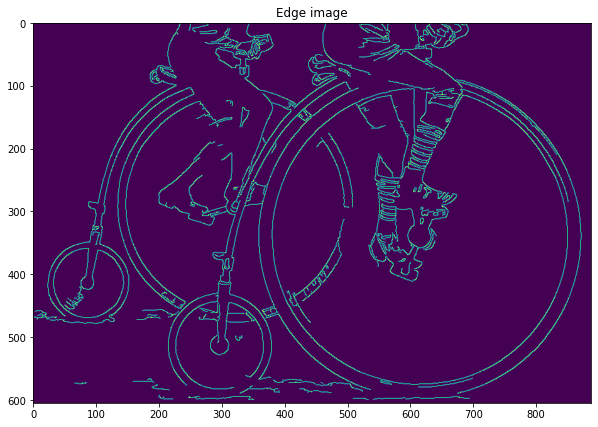

In [36]:
penny_path="data/input/penny_farthing.png"
penny_im = cv2.imread(penny_path, cv2.IMREAD_GRAYSCALE)
blurred_penny = cs4243_blur(penny_im, make_gaussian_kernel(3,3))
d_mag, d_angle= estimate_gradients(blurred_penny)
supp = non_maximum_suppression(d_mag, d_angle, False)
weak_edges, strong_edges = double_thresholding(supp, 0.2, 0.5)

penny_edge = edge_linking(weak_edges, strong_edges)

**QUESTION:** Comment on your result. Repeat the process with different interval sizes for R, X, and Y (set them all to 3 and 5 in the function `hough_vote_circles_grad`). Explain the difference in result as compared to when the interval size was 1. What do you think will happen if the interval size is set to a large value like 10 or 20?

(Hint: You may want to pull out the `find_peak_params` function and observe the local maxima.)

**ANSWER:**

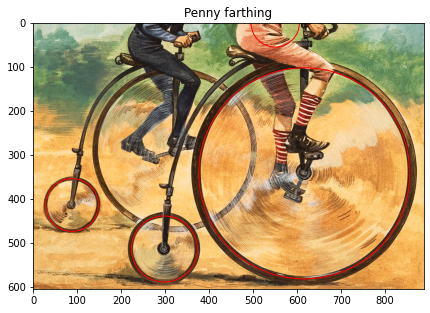

In [38]:
u = hough_vote_circles_grad(penny_edge, d_angle, [50, 260])
# If you change the bin size, be careful with the parameter window_size
penny_local = find_peak_params(u[0], [u[1],u[2],u[3]],10,0.4)
draw_circles_v2(penny_local, penny_path, "Penny farthing")

Expected answer below:

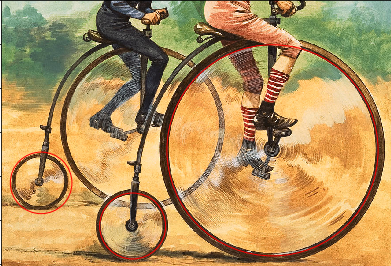

In [ ]:
from IPython.display import Image, display
display(Image("data/output/penny_ans.png", width=400, height=300))

**4.4 Gaussian Sigma (10%)**

More experimentation on the impact of `sigma` (parameter for the gaussian kernel) on edge image and circle detection result.

(For this part, do not change the kernel size)

Let's look at an image of some cells

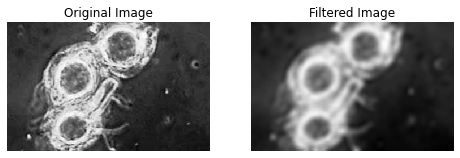

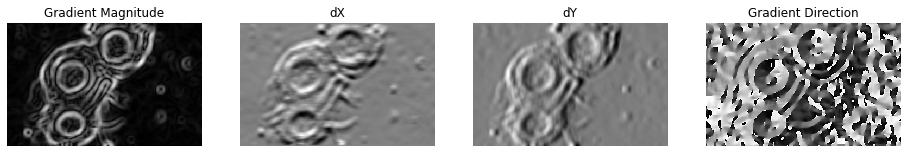

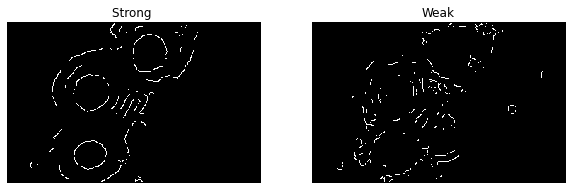

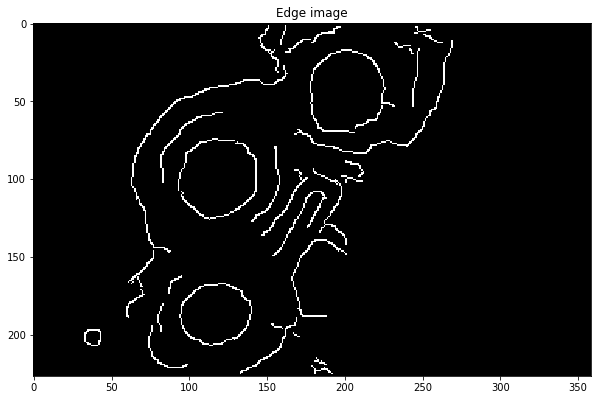

In [ ]:
cell_path="data/input/cells.png"
cell_im = cv2.imread(cell_path, cv2.IMREAD_GRAYSCALE)
blurred_cell = cs4243_blur(cell_im, make_gaussian_kernel(13,5))
d_mag, d_angle= estimate_gradients(blurred_cell)
supp = non_maximum_suppression(d_mag, d_angle, False)
weak_edges, strong_edges = double_thresholding(supp, 0.3, 0.5)

cell_edge = edge_linking(weak_edges, strong_edges)

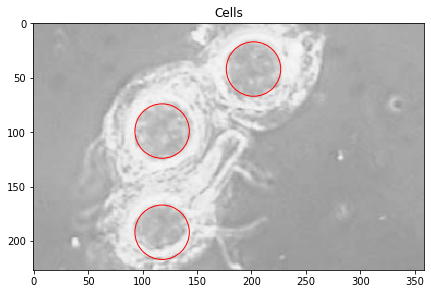

In [ ]:
# Feel free to use either hough_vote_circles or hough_vote_circles_grad
u = hough_vote_circles(cell_edge, [25, 30])

cell_local = find_peak_params(u[0], [u[1],u[2],u[3]],3,0.6)
draw_circles_v2(cell_local, cell_path, "Cells")

Expected answer below:

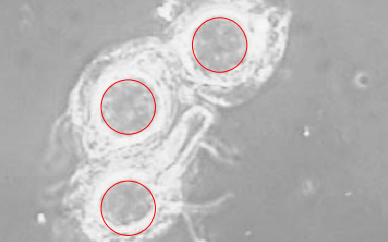

In [ ]:
from IPython.display import Image, display
display(Image("data/output/cells_ans.png", width=370, height=250))

And some flowers 

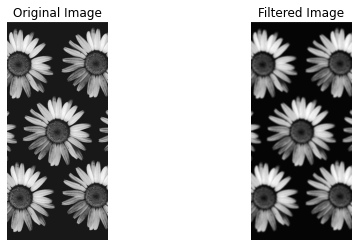

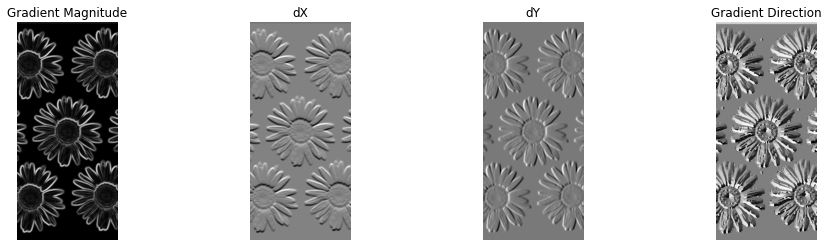

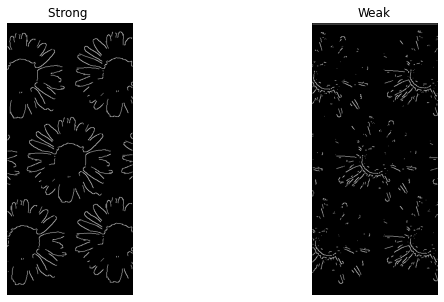

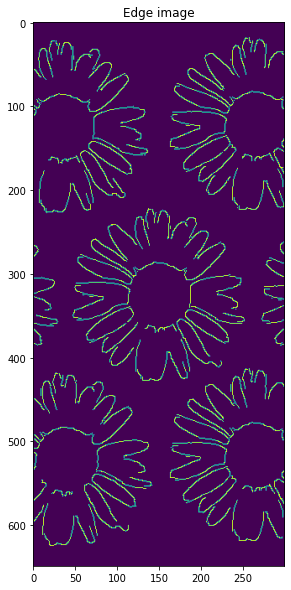

In [84]:
flower_path="data/input/sunflower.png"
flower_im = cv2.imread(flower_path, cv2.IMREAD_GRAYSCALE)
blurred_flower = cs4243_blur(flower_im, make_gaussian_kernel(5,5))
d_mag, d_angle= estimate_gradients(blurred_flower)
supp = non_maximum_suppression(d_mag, d_angle, False)
weak_edges, strong_edges = double_thresholding(supp, 0.2, 0.4)
flower_edge = edge_linking(weak_edges, strong_edges)

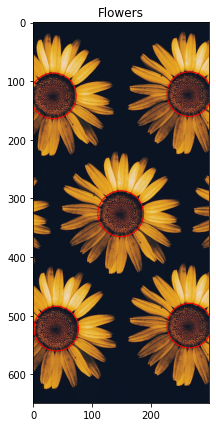

In [89]:
# Feel free to use either hough_vote_circles or hough_vote_circles_grad
u = hough_vote_circles(flower_edge, [25, 50])

flower_local = find_peak_params(u[0],[u[1],u[2],u[3]],10,0.75)
draw_circles_v2(flower_local, flower_path, "Flowers")

Expected answer below:

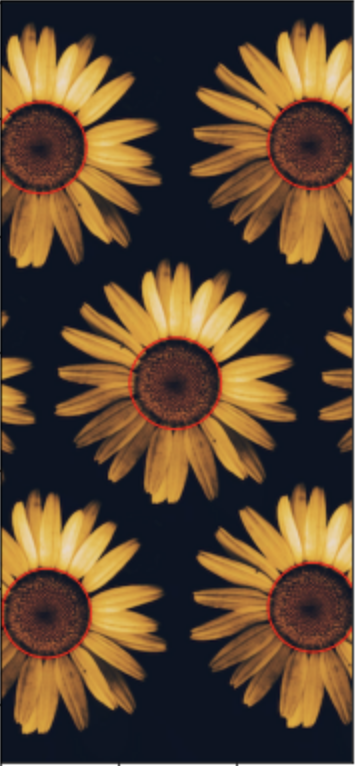

In [92]:
from IPython.display import Image, display
display(Image("data/output/sunflower_ans.png", width=200))

**QUESTION:** Perform circle detection for each sigma and comment on the quality of the edge and circle detection. What impact does changing sigma have on detecting the circles and why?

**ANSWER:**

This is the end. Please check the notebook. If the content is all right to you, make sure to follow the submission instructions correctly.

Good work :)
